# LinearSVC trained with fastText embeddings (RQ2)

In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.svm import LinearSVC
from gensim.downloader import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA

### Load the data

In [2]:
# Load the training data 
X_train = pd.read_csv("data/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train = pd.read_csv("data/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the validation data 
X_val = pd.read_csv("data/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val = pd.read_csv("data/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the test data 
X_test = pd.read_csv("data/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test = pd.read_csv("data/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

I will be using the `fasttext-wiki-news-subwords-300` model. This is a pre-trained word embedding model provided by Facebook's AI Research (FAIR) team. The model is trained on a large corpus of Wikipedia articles and news data, and it includes subword information to handle out-of-vocabulary (oov) words. The dimensionality of the word vectors is 300.

In [4]:
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

To use the pre-trained FastText word embeddings with an SVC model, we need to first convert the pre-processed tweets into a format that can be used for training the model. This involves converting the tweets into numerical representations using the loaded pre-trained embeddings.


#### Convert each tweet in the training, validation, and test sets into a sequence of FastText embeddings 


In [5]:
def tweet_to_embedding(tweet):
    words = tweet.split() # split tweet into words
    embeddings = [] # here we can store the word embeddings
    for word in words:
        if word in fasttext_model: # check if word already exists in the fastText model
            embeddings.append(fasttext_model[word]) # retrieve the embedding & add it to the embeddings list
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0) # compute mean of the word embeddings to create an overall tweet embedding
    else:
        return np.zeros(fasttext_model.vector_size) # return a 0 vector if no embeddings are found

X_train_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_train]) # generate tweet embeddings for training set
X_val_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_val])  # generate tweet embeddings for val set
X_test_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_test])  # generate tweet embeddings for test set


The code above splits each tweet into its constituent words, then looks up the GloVe embedding for each word. If the word is not found in the FastText vocabulary, it is ignored. The embeddings for each word in the tweet are averaged to obtain a single embedding for the entire tweet.



## PCA

In [6]:
# Generate feature vectors for the training set
X_train_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_train])

# Apply PCA to reduce the dimensionality of the feature space
pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train_embeddings)

# Generate feature vectors for the validation set
X_val_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_val])

# Apply PCA to reduce the dimensionality of the feature space
X_val = pca.transform(X_val_embeddings)

# Generate feature vectors for the test set
X_test_embeddings = np.array([tweet_to_embedding(tweet) for tweet in X_test])

# Apply PCA to reduce the dimensionality of the feature space
X_test = pca.transform(X_test_embeddings)

### Perform hyperparameter tuning
Perform a grid search over different values of `C` and `class_weight` using 5-fold cross-validation and the `f1_macro` scoring metric. The F1 macro is used as a scoring metric since we are dealing with an imbalanced dataset. The F1 macro calculates the F1 score for each class independently and then takes the average across all classes, giving equal weight to each class regardless of their size. This is particularly important because in our imbalanced data, the classifier may tend to favor the majority class (Negative and Positive reviews), leading to poor performance on the minority class (Neutral reviews).

In [7]:
# Define the parameter grid to search over
param_grid = {'C': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 5, 8, 10, 15],     
              'class_weight': [None, 'balanced'],} 

# Create a LinearSVC object
svc = LinearSVC(max_iter=10000)

# Create a GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_embeddings, y_train)

# Get the best estimator from the grid search
best_svc = grid_search.best_estimator_

# Predict labels for the validation set
y_val_pred = best_svc.predict(X_val_embeddings)

# Print the classification report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1395
           1       0.53      0.59      0.56       727
           2       0.76      0.74      0.75      1674

    accuracy                           0.70      3796
   macro avg       0.67      0.68      0.68      3796
weighted avg       0.71      0.70      0.70      3796



In [8]:
# Print the best hyperparameters and the corresponding F1 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparameters: {'C': 3, 'class_weight': 'balanced'}
Best F1 score: 0.6718373092310819


### Train LinearSVC with best hyperparameters
After selecting the best hyperparameters using the validation set, the model will be trained on the entire training set which includes both the original training data and the validation data. Once the model is trained, it will be evaluated on the test set to assess its performance.

In [9]:
# Merge X values
X_train_val_embeddings = np.concatenate((X_train_embeddings, X_val_embeddings))

# Merge y values
y_train_val = pd.concat([y_train, y_val])

Accuracy score: 69.52%
Classification report:

Class	Precision	Recall		F1-score	Support
-------------------------------------------------------
0	0.73		0.73		0.73		1633
1	0.52		0.61		0.56		617
2	0.74		0.69		0.71		1546
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1633
           1       0.52      0.61      0.56       617
           2       0.74      0.69      0.71      1546

    accuracy                           0.70      3796
   macro avg       0.66      0.68      0.67      3796
weighted avg       0.70      0.70      0.70      3796



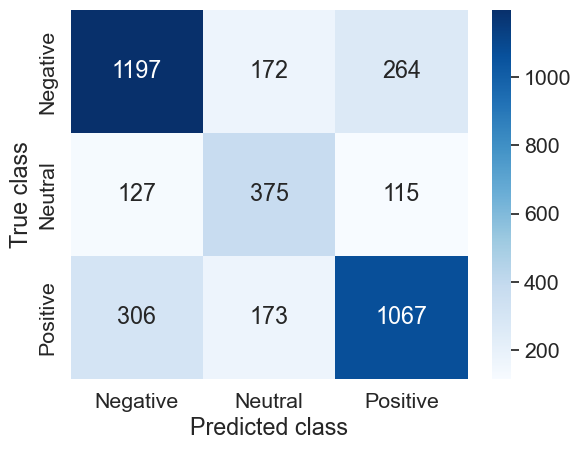

In [10]:
# Fit the model with best hyperparameters on the merged data
svc = LinearSVC(C=3, class_weight='balanced')
svc.fit(X_train_val_embeddings, y_train_val)

# Evaluate the performance of the pipeline on the test set
y_test_pred = svc.predict(X_test_embeddings)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy score: {:.2f}%".format(accuracy * 100))

# Calculate precision, recall, f1-score and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Print the classification report
print("Classification report:\n")
print("Class\tPrecision\tRecall\t\tF1-score\tSupport")
print("-" * 55)
for i in range(len(precision)):
    print("{}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{}".format(i, precision[i], recall[i], f1[i], support[i]))
print("-" * 55)

# print the classification report
print(classification_report(y_test, y_test_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])

# Plot the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [11]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    
    # Weighted Metrics
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Recall:", weighted_recall)
    print("Weighted Precision:", weighted_precision)
    print("Weighted F1 Score:", weighted_f1)


In [12]:
evaluate_model(svc, X_test_embeddings, y_test)

Confusion Matrix:
[[1197  172  264]
 [ 127  375  115]
 [ 306  173 1067]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1633
           1       0.52      0.61      0.56       617
           2       0.74      0.69      0.71      1546

    accuracy                           0.70      3796
   macro avg       0.66      0.68      0.67      3796
weighted avg       0.70      0.70      0.70      3796

Weighted Recall: 0.6952054794520548
Weighted Precision: 0.7010924654952403
Weighted F1 Score: 0.6972794998118992


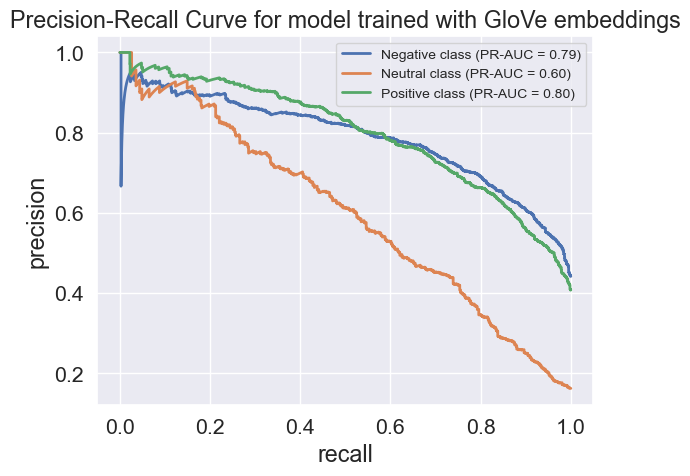

In [13]:
n_classes = 3

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# fit classifier and predict decision scores
decision_scores = svc.decision_function(X_test_embeddings)

# calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()

class_names = [(0,'Negative'),(1,'Neutral'), (2,'Positive')]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], decision_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], decision_scores[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best",fontsize=10)
plt.title("Precision-Recall Curve for model trained with GloVe embeddings")
plt.show()


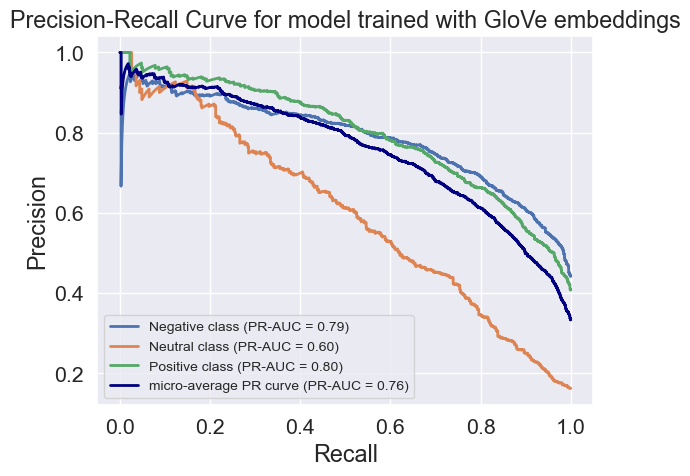

In [14]:
# Precision-Recall curve with Micro averaging for multiclass classification
from sklearn.preprocessing import LabelBinarizer

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# fit classifier and predict scores
y_score = svc.decision_function(X_test_embeddings)

# calculate precision and recall for each class using one-vs-all approach
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
# calculate micro-averaged precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# plot overall micro-averaged precision-recall curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='micro-average PR curve (PR-AUC = {0:0.2f})'
               ''.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best", fontsize=10)
plt.title('Precision-Recall Curve for model trained with GloVe embeddings')
plt.show()


This plots only the micro-average curve in the Precision-Recall plot. The micro-average curve is a weighted average of precision and recall computed over all classes, and is often used in multiclass classification problems.

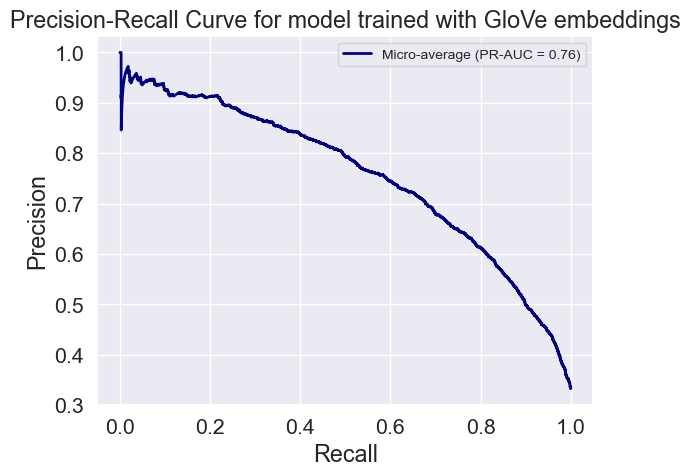

In [15]:
# Convert y_test to binary label matrix
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit classifier and predict probabilities
y_score = svc.decision_function(X_test_embeddings)

# Calculate precision and recall using micro averaging
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())

# Calculate average precision score using micro averaging
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# Plot micro-average curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='Micro-average (PR-AUC = {0:0.2f})'.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best', fontsize=10)
plt.title('Precision-Recall Curve for model trained with GloVe embeddings')
plt.show()


#### Save Precision-Recall Curve

In [16]:
#np.save('Precision-Recall Curves/precision_micro_fasttext.npy', precision_micro)
#np.save('Precision-Recall Curves/recall_micro_fasttext.npy', recall_micro)

In [ ]:
# load the array from file
#precision_micro_w2vec = np.load('Precision-Recall Curves/precision_micro_fasttext.npy')
#recall_micro_w2vec = np.load('Precision-Recall Curves/recall_micro_fasttext.npy')